In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import math
import copy
import scipy.sparse
import scipy.sparse.linalg
import scipy.optimize as scopt
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
import cvxpy as cvx
import itertools
import skimage
from nanomesh import Image, Mesher2D

In [2]:
def MatPrint(mat, fmt="g"):
    # Prints matrixes in an organized way
    # https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="   ")
        print("")


def Force(xa, xb, ua, ub, e, a, k):
    # Receives a link from the truss and deduces the axial force applied on it based on its deformation
    l0 = np.linalg.norm(xb-xa)
    xaf = xa + ua
    xbf = xb + ub
    lf = np.linalg.norm(xbf-xaf)
    eab = (xbf-xaf)/lf
    return np.linalg.norm(eab*(e*a[k]*(lf-l0)/l0))


def Loads(conec, coord, desloc, e, a):
    # Applies the Force() funcion on each link and creates an array containing all axial forces ().
    nl = a.size
    forces = np.zeros(nl)
    for k in range(nl):
        ia = int(conec[k][0])
        ib = int(conec[k][1])
        xa = np.vstack(coord[ia-1])
        xb = np.vstack(coord[ib-1])
        ua = np.vstack(np.array([desloc[2 * ia - 2], desloc[2 * ia-1]]))
        ub = np.vstack(np.array([desloc[2 * ib - 2], desloc[2 * ib-1]]))
        forces[k] = Force(xa, xb, ua, ub, e, a, k)
    return forces


def Stiffness2(conec, coord, mod):
    # Based on a truss's characteristics, computes its stiffness matrix (currently works for 2-dimensional problems)
    nl = mod.size
    [nv, syscoord] = coord.shape
    kg = np.zeros((syscoord*nv, syscoord*nv))
    for k in range(nl):
        ia = int(conec[k][0])-1
        ib = int(conec[k][1])-1
        xa = coord[ia]
        xb = coord[ib]
        d = np.vstack(xb-xa)
        l0 = np.linalg.norm(d)
        aux = mod[k]/(l0**3)
        mat = aux*(d*(xb-xa))
        kb = np.array(np.bmat([[mat, -mat], [-mat, mat]]))
        loc = []
        for i in range(syscoord):
            loc.append(syscoord*ia + i)
        for i in range(syscoord):
            loc.append(syscoord*ib + i)
        for i in range(4):
            for j in range(4):
                ig = loc[i]
                jg = loc[j]
                kg[ig][jg] = kg[ig][jg] + kb[i][j]
    return kg


# def rigidez3(nl, nv, conec, coord, mod):


def plotl(conec, p, m, c):
    # Simple plot for the truss
    nl = len(conec)
    pp = np.zeros((2, 2))
    for i in range(nl):
        pp[0, 0] = p[int(conec[i][0])-1][0]
        pp[0, 1] = p[int(conec[i][0])-1][1]
        pp[1, 0] = p[int(conec[i][1])-1][0]
        pp[1, 1] = p[int(conec[i][1])-1][1]
        plt.plot(pp[:, 0], pp[:, 1], marker=m, color=c)


def plotltens(conec, p, m, t, a):
    # Plots the deformed truss (proportionally), as well as each link's tension (by color) and transversal area
    # 'jet', 'viridis', 'gist_rainbow'**-1, 'nipy_spectral'
    viridis = cm.get_cmap(colorsT, len(t))
    nl = a.size
    auxi = max(abs(np.array(t)))
    auxi2 = max(a)-min(a)
    pp = np.zeros((2, 2))
    lwidth = np.digitize(a, [min(a)+0.0005*auxi2, min(a)+0.1*auxi2,min(a)+0.2*auxi2, min(a)+0.3*auxi2, min(a)+0.4*auxi2,
                             min(a)+0.5*auxi2, min(a)+0.6*auxi2, min(a)+0.7*auxi2, min(a)+0.8*auxi2, min(a)+0.9*auxi2,
                             min(a)+auxi2])
    # print(lwidth)
    for i in range(nl):
        pp[0, 0] = p[int(conec[i][0])-1][0]
        pp[0, 1] = p[int(conec[i][0])-1][1]
        pp[1, 0] = p[int(conec[i][1])-1][0]
        pp[1, 1] = p[int(conec[i][1])-1][1]
        # viridis(tension[i]/auxi)
        plt.plot(pp[:, 0], pp[:, 1], marker=m, color=viridis(t[i]/auxi), linewidth=lwidth[i])


def plotlarea(conec, p, m, a):
    # Plots the deformed truss (proportionally), as well as each link's transversal area, by colour
    nl = len(conec)
    auxi = max(a)
    pp = np.zeros((2, 2))
    lwidth = 2
    for i in range(nl):
        pp[0, 0] = p[int(conec[i][0])-1][0]
        pp[0, 1] = p[int(conec[i][0])-1][1]
        pp[1, 0] = p[int(conec[i][1])-1][0]
        pp[1, 1] = p[int(conec[i][1])-1][1]
        # viridis(tension[i]/auxi)
        plt.plot(pp[:, 0], pp[:, 1], marker=m, color='black', alpha=abs(a[i])/auxi, linewidth=lwidth)


def forcexy(farr):
    # Receives the load input array [module, node, direction (x or y)] and returns it in an ordered way so that the code
    # can process it
    fno = []
    fxy = []
    k = 2
    while k <= len(farr):
        u = farr[k]
        if u == 0:  # Aplica a força em X
            fno.append(farr[k-2])
            fxy.append((farr[k-1]-1)*2)
            k = k+3
        elif u == 1:  # Aplica a força em Y
            fno.append(farr[k-2])
            fxy.append((farr[k-1]-1)*2+1)
            k = k+3
        elif u == 2:  # Aplica a força em X e Y
            fno.append(farr[k-2])
            fno.append(farr[k-2])
            fxy.append((farr[k-1]-1)*2)
            fxy.append((farr[k-1]-1)*2+1)
            k = k+3
    return fno, fxy


def dellink(conec, linkdel, a):
    # (Completely) erases a link from the truss, based on its pair of nodes
    conecauxbd = copy.deepcopy(conec)
    aauxbd = copy.deepcopy(a)
    for i in linkdel:
        conecauxbd = np.delete(conecauxbd, i, 0)
        aauxbd = np.delete(aauxbd, i, 0)
    return conecauxbd, aauxbd


def compvol(coord, conec, a):
    # Computes the truss's total volume
    vol = 0
    for i, area in enumerate(a):
        conecaux = conec[i]
        na = int(conecaux[0])-1
        nb = int(conecaux[1])-1
        d = math.sqrt((coord[nb][0] - coord[na][0]) ** 2 + (coord[nb][1] - coord[na][1]) ** 2)
        vol = vol + float(d*a[i])
    return vol


def compvoljac(coord, conec, a):
    # Computes the truss's total volume
    # print("compvoljac (teste)")
    dvol = np.zeros(np.size(a))
    for i, area in enumerate(a):
        conecaux = conec[i]
        na = int(conecaux[0])-1
        nb = int(conecaux[1])-1
        d = math.sqrt((coord[nb][0] - coord[na][0]) ** 2 + (coord[nb][1] - coord[na][1]) ** 2)
        dvol[i] = d
    return dvol


def compenergy(desloc, force):
    # Computes the truss's total energy
    eg = 0
    for i in range(len(desloc)):
        eg = eg + desloc[i]*force[i]
    return eg


def breakdesloc(desloc):
    # breaks the [2*nl, 1] desloc array into a [nl, 2]
    deslocaux = np.zeros((nv, 2))
    for i in range(nv):
        deslocaux[i][0] = desloc[2 * i]
        deslocaux[i][1] = desloc[2 * i + 1]
    return deslocaux


def tension(force, area):
    # Computes the tension in every link
    auxiliary = []
    for i, ii in enumerate(area):
        if ii < 0.00000001:
            auxiliary.append(0)
        else:
            auxiliary.append(force[i]/area[i])
    return auxiliary


def restrictaux(config, coord):
    # Prepares the input array for restricting
    a = config[0]  # Line - 0 or Column - 1
    b = config[1]  # First - 0 or Last - 1
    u = []
    for c in config[2]:  # 0 restricts x coordinate and 1 the y coordinate
        xmax = max(coord[:, 0])
        ymax = max(coord[:, 1])
        if c == 0:
            if a == 0:  # Restricts a line
                if b == 0:  # Lower
                    for i, ii in enumerate(coord):
                        if float(ii[1]) == 0:
                            u.append(2*i)
                elif b == 1:  # Upper
                    for i, ii in enumerate(coord):
                        if float(ii[1]) == ymax:
                            u.append(2*i)
            elif a == 1:  # Restricts a column
                if b == 0:  # left
                    for i, ii in enumerate(coord):
                        if float(ii[0]) == 0:
                            u.append(2*i)
                elif b == 1:  # right
                    for i, ii in enumerate(coord):
                        if float(ii[0]) == xmax:
                            u.append(2*i)
        elif c == 1:
            if a == 0:  # Restricts a line
                if b == 0:  # Lower
                    for i, ii in enumerate(coord):
                        if float(ii[1]) == 0:
                            u.append(2 * i+1)
                elif b == 1:  # Upper
                    for i, ii in enumerate(coord):
                        if float(ii[1]) == ymax:
                            u.append(2 * i+1)
            elif a == 1:  # Restricts a column
                if b == 0:  # left
                    for i, ii in enumerate(coord):
                        if float(ii[0]) == 0:
                            u.append(2*i+1)
                elif b == 1:  # right
                    for i, ii in enumerate(coord):
                        if float(ii[0]) == xmax:
                            u.append(2 * i+1)
    return u


def computelength(coord, conec):
    tlength = 0
    for i in range(conec.shape[0]):
        na = int(conec[i][0])-1
        nb = int(conec[i][1])-1
        d = np.linalg.norm((coord[nb][:]-coord[na][:]))
        tlength = tlength + d
    return tlength


def importtruss(path):
    conecaux = np.loadtxt(path+'\conec.txt')
    coordaux = np.loadtxt(path+'\coord.txt')
    a = np.loadtxt(path+'\Area.txt')
    return conecaux, coordaux, a


def solvetruss(conec, coord, farr, a, e):
    time0 = time.time()
    if syscoord == 2:
        timekg = time.time()
        nl = conec.shape[0]
        mod = e*a
        kg = Stiffness2(nl, conec, coord, mod)
        print("\nTime creating kg:", time.time()-timekg, "s")
        kr = np.copy(kg)
        timekr = time.time()
        iden = np.identity(2*nv)
        for u in restSettings:
            kr[u] = iden[u]
        print("Time restricting truss:", time.time()-timekr, "s")
        f = np.zeros((2*nv, 1))
        fno, fxy = forcexy(farr)
        for k, kk in enumerate(fxy):
            f[kk] = fno[k]
        krs = sc.sparse.csr_matrix(kr)
        soltime = time.time()
        desloc = sc.sparse.linalg.spsolve(krs, f)
        forces = Loads(conec, coord, desloc, e, a, nl)
        im = np.argmax(np.abs(forces))
        maximum = forces[im]
        print("Solution time:", time.time()-soltime, "s")
    print("Total time:", time.time() - time0, "s")
    return desloc, krs, forces
    # elif syscoord == 3:


def energy(a, conec, coord, farr, e, iden):
    mod = e*a
    kr = Stiffness2(conec, coord, mod)
    for u in restSettings:
        kr[u] = iden[u]
    f = np.zeros((2*nv, 1))
    fno, fxy = forcexy(farr)
    for k in np.arange(len(fxy)):
        f[fxy] = fno[k]
    krs = sc.sparse.csr_matrix(kr)
    desloc = sc.sparse.linalg.spsolve(krs, f)
    energyres = desloc.T@krs@desloc
    return energyres


def complen(nl, conec, coord):
    dist = []
    for i in range(nl):
        conecaux = conec[i]
        na = int(conecaux[0])-1
        nb = int(conecaux[1])-1
        dist.append(math.sqrt((coord[nb][0] - coord[na][0]) ** 2 + (coord[nb][1] - coord[na][1]) ** 2))
    return dist


def comppjpm(coord, conec, a):  # Computes the "projected perimeter"
    pp = 0
    for i, m in enumerate(conec):
        if a[i] > areafloor:
            pp = pp+np.sqrt((coord[int(m[1])-1]-coord[int(m[0])-1])**2)
    pphist.append(pp)

    # ------------------------
    # print("max coord", max(coord))
    # print("min coord", min(coord))
    # ------------------------

    return pp


#------------------------------------------------------------------------------------------


def calcB(coord, conecl, dof):

    m, n1, n2 = len(conecl), (conecl[:,0].astype(int)-1), (conecl[:,1].astype(int)-1)

    # ------------------------
    # print("m", m, "n1", n1, "n2", n2)
    # ------------------------

    l, X, Y = conecl[:,2], coord[n2,0]-coord[n1,0], coord[n2,1]-coord[n1,1]

    #------------------------
    # print("l", l, "X", X, "Y", Y)
    # ------------------------

    d0, d1, d2, d3 = dof[n1*2], dof[n1*2+1], dof[n2*2], dof[n2*2+1]
    s = np.concatenate((-X/l * d0, -Y/l * d1, X/l * d2, Y/l * d3))
    r = np.concatenate((n1*2, n1*2+1, n2*2, n2*2+1))
    c = np.concatenate((np.arange(m), np.arange(m), np.arange(m), np.arange(m)))
    return sc.sparse.coo_matrix((s, (r, c)), shape=(len(coord)*2, m))


def penalization(conecl, coord, dirproj, penalty):
    p = []
    for i, m in enumerate(conecl):
        lx = abs(coord[int(m[1]) - 1][0] - coord[int(m[0]) - 1][0])
        ly = abs(coord[int(m[1]) - 1][1] - coord[int(m[0]) - 1][1])
        if dirproj == "x":
            p.append(lx / np.sqrt(lx ** 2 + ly ** 2)*penalty+1.e-3)
        elif dirproj == "y":
            p.append(ly / np.sqrt(lx ** 2 + ly ** 2) * penalty + 1.e-3)
        # p.append(1 / np.sqrt(lx ** 2 + ly ** 2)+1.e-3)
        # p.append(lx + 1 / np.sqrt(lx ** 2 + ly ** 2)+1.e-3)
        # p.append(lx/np.sqrt(lx**2+ly**2)+1/np.sqrt(lx**2+ly**2))
    return p


def solvelp(coord, conecl, f, dof, stt, stc):
    l = [col[2] for col in conecl]
    B = calcB(coord, conecl, dof)

    #-------------------------
    # print("B", B.todense())
    # BBB = B.todense()
    # print("type", type(BBB))
    # MatPrint(np.array(BBB))
    #-------------------------

    a = cvx.Variable(len(conecl))
    penal = penalization(conecl, coord, dirproj, penalty)

    # -------------------------
    # print("a then", a)
    # -------------------------

    # obj = cvx.Minimize(np.transpose(l) @ a)
    # obj = cvx.Minimize(np.transpose(cvx.multiply(l, penal).value) @ a)
    obj = cvx.Minimize(np.transpose(l + cvx.multiply(l, penal).value) @ a)
    q, eqn, cons = [],  [], [a >= 0]
    q.append(cvx.Variable(len(conecl)))
    eqn.append(B @ q[0] == f[0] * dof)
    cons.extend([eqn[0], q[0] >= -stc * a, q[0] <= stt * a])
    prob = cvx.Problem(obj, cons)
    vol = prob.solve(warm_start=True)
    q = [np.array(qi.value).flatten() for qi in q]
    a = np.array(a.value).flatten()
    u = [-np.array(eqnk.dual_value).flatten() for eqnk in eqn]

    #-------------------------
    # print("u", u)
    #-------------------------


    return vol, a, q, u


def stopViolation(coord, conecl, dof, stt, stc, u):
    lst = np.where(conecl[:,3]==False)[0]
    Cn = conecl[lst]
    l = Cn[:,2]
    B = calcB(coord, Cn, dof).tocsc()
    y = np.zeros(len(Cn))
    for uk in u:
        yk = np.multiply(B.transpose().dot(uk) / l, np.array([[stt], [-stc]]))
        y += np.amax(yk, axis=0)
    vioCn = np.where(y>1.0001)[0]
    vioSort = np.flipud(np.argsort(y[vioCn]))
    num = math.ceil(min(len(vioSort), 0.05*max([len(Cn)*0.05, len(vioSort)])))
    for i in range(num):
        conecl[lst[vioCn[vioSort[i]]]][3] = True
    return num == 0


def trussopt(coord, f, dof, stt, stc, mbadd):
    energyhist = []
    maxahist = []
    meanahist = []
    vhist = []
    conecl = []
    for k, ii in enumerate(conec):
        i = int(ii[0]) - 1
        j = int(ii[1]) - 1
        dx, dy = abs(coord[i][0] - coord[j][0]), abs(coord[i][1] - coord[j][1])
        conecl.append([conec[k][0], conec[k][1], np.sqrt(dx ** 2 + dy ** 2), False])
    conecl = np.array(conecl)
    for pm in [p for p in conecl if p[2] <= mbadd]:
        pm[3] = True
    print('Nodes: %d Members: %d' % (len(coord), len(conecl)))
    f = [f]
    inittime = time.time()
    for itr in range(1, maxiter):
        Cn = conecl[conecl[:,3] == True]  # LINKS LIST AND THEIR LENGTH [(N1,N2,L,BOOL))]
        vol, a, q, u = solvelp(coord, Cn, f, dof, stt, stc)
        vhist.append(vol)
        for i, ii in enumerate(a):
            if ii <-0.001:
                print("Negative Area")
        maxahist.append(max(a))
        meanahist.append(np.mean(a))
        k = 0
        aaux = np.zeros(len(conec))
        for i, p in enumerate(conecl):
            if p[3] == False:
                aaux[i] = 0
            else:
                aaux[i] = a[k]
                k += 1
        # eee = energy(aaux, conecaux, coord, farr, e, iden = np.identity(2*nv))
        # print("Energy:", eee)
        if stopViolation(coord, conecl, dof, stt, stc, u):
            break
    # Plotting the final truss:
    aaux = np.zeros(len(conec))
    ttt = 0
    k = 0
    for i in conecl:
        if i[3] == True:
            ttt += 1
    for i, p in enumerate(conecl):
        if p[3] == False:
            aaux[i] = 0
        else:
            aaux[i] = a[k]
            k += 1
    deslocaux = breakdesloc(u[0])
    faux = np.zeros(len(aaux))
    k = 0
    for i, ii in enumerate(aaux):
        if ii == 0:
            faux[i] = 0
        else:
            faux[i] = q[0][k]
            k += 1
    tens = tension(faux, aaux.T)
    return aaux, tens


def plotbinary(conec, p, a):
    # Plots the deformed truss (proportionally), as well as each link's tension (by color) and transversal area
    # 'jet', 'viridis', 'gist_rainbow'**-1, 'nipy_spectral'
    nl = a.size
    auxi2 = max(a)-min(a)
    pp = np.zeros((2, 2))
    lwidth = np.digitize(a, [min(a)+0.0005*auxi2, min(a)+0.1*auxi2,min(a)+0.2*auxi2, min(a)+0.3*auxi2, min(a)+0.4*auxi2,
                             min(a)+0.5*auxi2, min(a)+0.6*auxi2, min(a)+0.7*auxi2, min(a)+0.8*auxi2, min(a)+0.9*auxi2,
                             min(a)+auxi2])
    # print(lwidth)
    for i in range(nl):
        pp[0, 0] = p[int(conec[i][0])-1][0]
        pp[0, 1] = p[int(conec[i][0])-1][1]
        pp[1, 0] = p[int(conec[i][1])-1][0]
        pp[1, 1] = p[int(conec[i][1])-1][1]
        # viridis(tension[i]/auxi)
        plt.plot(pp[:, 0], pp[:, 1], color='black', linewidth=lwidth[i])
        plt.axis('off')

In [3]:
# Importing (and declaring) truss data:
conec = np.loadtxt("\ex\gerado\conec.txt")
nl = conec.shape[0]
print("SIZE: ", conec.shape)
conecaux = copy.deepcopy(conec)
coord = np.loadtxt("\ex\gerado\coord.txt")
[nv, syscoord] = coord.shape
coordaux = copy.deepcopy(coord)

e = 1
stc = 1
stt = 1

SIZE:  (634, 2)


In [4]:
farr = [-1, 27, 1]  # force module, node, direction (x=0, y=1)
f = []
fno, fxy = forcexy(farr)
k = 0
for i in range(0, 2 * nv):
    if k < len(fxy):
        if i == fxy[k]:
            f.append(fno[k])
            k += 1
        else:
            f.append(0)
    else:
        f.append(0)

# restaux = 0  # 0 for full line/column restricted, 1 for custom restrictions. In case of the first option, [a, b, c],
# a being either 0 [line] or 1 [column], b being either 0 [first] or 1 [last] and c being either or both 0 [x] or/and
# 1 [y]:
restSettings = [10*2-2, 10*2-1, 28*2-2, 28*2-1]  # 2*[node number] - 2 for x restriction, 2*[node number] - 1 for y restriction
# restSettings = restrictaux([1, 0, [0, 1]], coordaux)
print("Restricted nodes:", restSettings)
dof = np.ones(2*nv)
for i in restSettings:
    dof[i] = 0
width = 1
while coord[width][0] != coord[0][0]:
    width += 1
diag = np.sqrt((coord[1][0]-coord[0][0])**2+(coord[width][1]-coord[0][1])**2)  # Computes the value of the length of the diagonal link between "neighbor" nodes

Restricted nodes: [18, 19, 54, 55]


In [5]:
# Declaring code specifications (plot color, number of iterations, tolerance, et cetera)
colorsT = 'jet'
colorsA = 'gray_r'
shownum = 1
showarea = 1
showaux = 1
webaux = 1
repeataux = 0
saveaux = 0  # 0 so that the program does not save data, 1 otherwise
if repeataux == 0:
    repeat = ''
else:
    repeat = '__repeat'
if webaux == 0:
    web = ''
else:
    web = '_web'

In [6]:
maxiter = 100
tolerance = 1.e-7
areafloor = 1.e-3
penalty = 0
dirproj = "x"
mbadd = 100  # Setting for member adding initial elements. Every member with length <= mbadd is used.
xmax = max(coord[:, 0])
ymax = max(coord[:, 1])
fhis = []
fpp = []

Nodes: 45 Members: 634
Final Volume: 41.88888888837414
Duration of optimization proccess: 0.019003629684448242 s


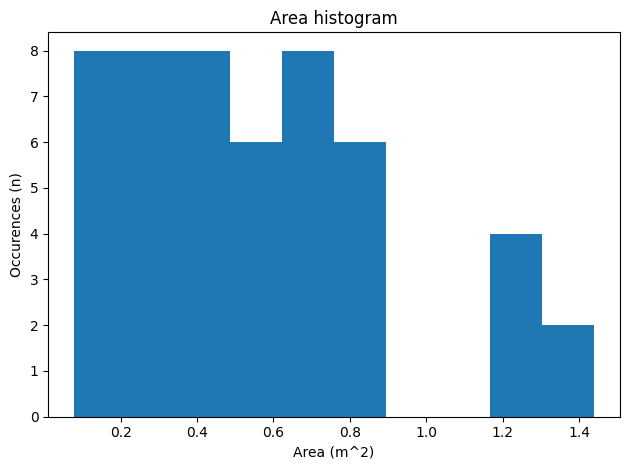

C:\Users\Arthur\AppData\Local\Temp\ipykernel_30124\2104497405.py:67: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(smT)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_30124\3247409942.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap(colorsT, len(t))
C:\Users\Arthur\AppData\Local\Temp\ipykernel_30124\2104497405.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal spac

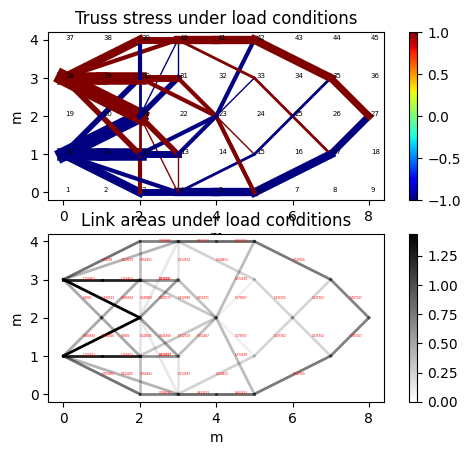

In [7]:
tempo = time.time()

aaux, tens = trussopt(coord, f, dof, stt, stc, mbadd)
print("Final Volume:", compvol(coord,conec,aaux))
print("Duration of optimization proccess:",time.time()-tempo, "s")
staaux = copy.deepcopy(aaux)

#####################################################################################################################################

if showaux == 1:
    specs = 'farr: {}     restSettings: {}'.format(farr, restSettings)
    path = (
        'IC\Datum\D_{}x{}\it{}_{}n_{}force_{}rest'.format(int(max(coord[:, 0])), int(max(coord[:, 1])),
                                                                 maxiter, coord.shape[0], farr,
                                                                 restSettings))
    path = path + web + repeat
    if saveaux == 1:
        if os.path.exists(path) == 0:
            os.makedirs(path)
        with open(path + '\specs.txt', 'w') as file:
            file.write(str(specs))
            file.write('\n\n')
            file.write("Total time optimizing: {}s".format(time.time() - inittime))
            file.write('\n\n')
            file.write("stt: {} / stc: {}".format(stt, stc))
            file.write('\n\n')
            file.write("Penalty: {}".format(penalty))
            file.write('\n\n')
            file.write("Projection: {}".format(dirproj))
            file.write('\n\n\n')
            file.write("Final Volume: {}".format(vol))
        np.savetxt(path + '\Area.txt', aaux)
        np.savetxt(path + '\coord.txt', coord)
        np.savetxt(path + '\conec.txt', conecaux)
        with open(path + '\desloc.txt', 'w') as file:
            file.write(str(u[0]))
        with open(path + '\energy.txt', 'w') as file:
            file.write(str(energyhist))
    #########################################################################################################
    fig = plt.figure(1)
    nonzeroA = []
    for i in aaux:
        if i > areafloor:
            nonzeroA.append(i)
    plt.hist(nonzeroA)
    plt.xlabel("Area (m^2)")
    plt.ylabel("Occurences (n)")
    plt.title("Area histogram")
    fig.tight_layout()
    if saveaux == 1:
        plt.savefig(path + '\datum.pdf', format='pdf')
    plt.show()
    #########################################################################################################
    fig = plt.figure(2)
    fig.tight_layout()
    if xmax >= ymax:
        ax1 = plt.subplot(2, 1, 1)
    else:
        ax1 = plt.subplot(1, 2, 1)
    if shownum == 1:
        for i in range(nv):
            plt.text(coord[i, 0] + 0.05, coord[i, 1] + 0.01, i + 1, fontsize=5)
    #########################################################################################################
    # https://medium.com/data-science-canvas/way-to-show-colorbar-without-calling-imshow-or-scatter-4a378058316
    smT = plt.cm.ScalarMappable(cmap=colorsT, norm=plt.Normalize(vmin=min(tens), vmax=max(tens)))
    smT._A = []
    plt.colorbar(smT)
    plotltens(conecaux, coord, None, tens, aaux)
    ax1.set_xlabel("m")
    ax1.set_ylabel("m")
    ax1.set_aspect(1)
    plt.title('Truss stress under load conditions')
    if xmax >= ymax:
        ax2 = plt.subplot(2, 1, 2)
    else:
        ax2 = plt.subplot(1, 2, 2)
    smA = plt.cm.ScalarMappable(cmap=colorsA, norm=plt.Normalize(vmin=min(aaux), vmax=max(aaux)))
    smA._A = []
    plt.colorbar(smA)
    plotlarea(conecaux, coord, None, aaux)
    ax2.set_xlabel("m")
    ax2.set_ylabel("m")
    plt.title("Link areas under load conditions")
    ax2.set_aspect(1)
    if showarea == 1:
        for i in range(nl):
            if aaux[i] > areafloor:
                plt.text(coord[int(conecaux[i,0])-1,0]+(coord[int(conecaux[i,1])-1,0]-coord[int(conecaux[i,0])-1,0])/2,
                         coord[int(conecaux[i,0])-1,1]+(coord[int(conecaux[i,1])-1,1]-coord[int(conecaux[i,0])-1,1])/2,
                         round(aaux[i], 6), fontsize=2, c="red")
    if saveaux == 1:
        print(path)
        plt.savefig(path + '\geometry.pdf', format='pdf')

#####################################################################################################################################
plt.show()

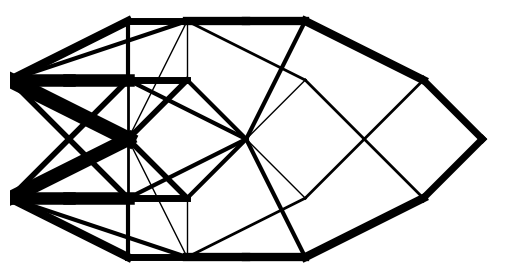

In [8]:
plotbinary(conecaux, coordaux, aaux)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.gca().set_xlim(left=0)
plt.savefig("test.png", bbox_inches='tight', pad_inches = 0)

In [9]:
print("START OF PROJECTED PERIMETER OPTIMIZATION")
pp = 0
for i, m in enumerate(conec):
    if aaux[i] > areafloor:
        pp = pp+abs(coord[int(m[1])-1][0]-coord[int(m[0])-1][0])
print("Post area-based volume optimization projected perimeter:", pp)

restrictednodes = []
for i in restSettings:
    if i % 2 == 0:  # Reinforces nodal X constraints
        restrictednodes.append(((i + 2) / 2) - 1)
    else:  # Reinforces nodal Y constraints
        if ((i - 1) / 2) not in restrictednodes:
            restrictednodes.append((i - 1) / 2)
#   -Restricts the movement for nodes where there's a load applied-
k = 1
while k <= len(farr):
    restrictednodes.append(farr[k]-1)
    k = k+3
#   -End-

# Getting the smallest distance between nodes on the truss
mindist = []
for m in conecaux:
    mindist.append(np.linalg.norm(abs(coordaux[int(m[1]) - 1] - coordaux[int(m[0]) - 1])))
mindist = min(mindist)
dist = 0.3

START OF PROJECTED PERIMETER OPTIMIZATION
Post area-based volume optimization projected perimeter: 58.0


C:\Users\Arthur\AppData\Local\Temp\ipykernel_30124\3355669672.py:14: RuntimeWarning: Maximum number of iterations has been exceeded.
  minimum = sc.optimize.minimize(comppjpm, coordaux[:, 0], args=(conecaux, aauxcopy), method='Nelder-Mead', bounds=bnds,


10.139062881469727


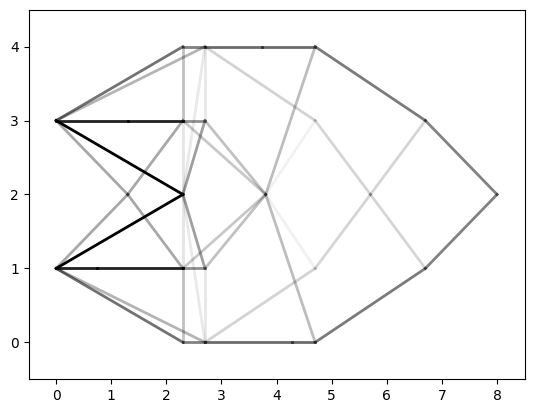

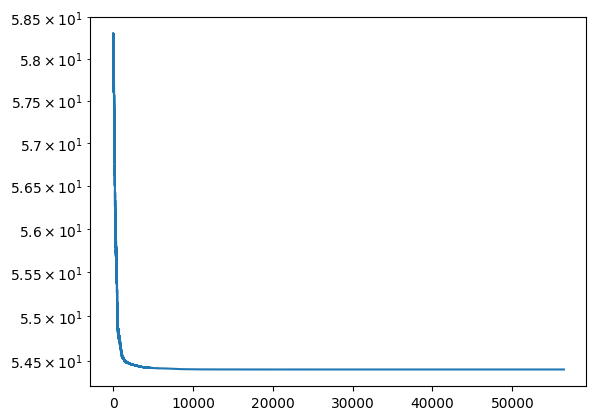

In [10]:
bnds = []
pphist = []
volhist = []
phist = []
penalty = 0
for i in range(len(coord)):
    if i in restrictednodes:
        bnds.append([coordaux[i, 0], coordaux[i, 0]])
    else:
        bnds.append([coordaux[i, 0]-dist, coordaux[i, 0]+dist])
aauxcopy = copy.deepcopy(aaux)
tempo = time.time()

minimum = sc.optimize.minimize(comppjpm, coordaux[:, 0], args=(conecaux, aauxcopy), method='Nelder-Mead', bounds=bnds,
                               options={'maxiter': 50000, 'disp': 1}, tol=tolerance)
print(time.time()-tempo)
coordopt = minimum.x
coordauxaux = copy.deepcopy(coordaux)
coordauxaux[:, 0] = coordopt
plotlarea(conecaux, coordauxaux, None, aaux)
plt.xlim(min(coordaux[:,0]-0.5),max(coordaux[:,0])+0.5)
plt.ylim(min(coordaux[:,1])-0.5,max(coordaux[:,1])+0.5)
plt.figure(3)
plt.plot(pphist)
plt.yscale('log')
plt.show()
volhist.append(compvol(coordauxaux, conecaux, aauxcopy))
phist.append(comppjpm(coordauxaux[:,0], conecaux, aauxcopy))

In [11]:
# bnds = []
# pphist = []
# volhist = []
# phist = []
# penalty = 10
# for i in range(len(coord)):
#     if i in restrictednodes:
#         bnds.append([coordaux[i, 0], coordaux[i, 0]])
#     else:
#         bnds.append([coordaux[i, 0]-dist, coordaux[i, 0]+dist])
# aauxcopy = copy.deepcopy(aaux)
# tempo = time.time()
# conecl = []
# for k, ii in enumerate(conec):
#     i = int(ii[0]) - 1
#     j = int(ii[1]) - 1
#     dx, dy = abs(coord[i][0] - coord[j][0]), abs(coord[i][1] - coord[j][1])
#     conecl.append([conec[k][0], conec[k][1], np.sqrt(dx ** 2 + dy ** 2), False])
# conecl = np.array(conecl)
# for pm in [p for p in conecl if p[2] <= mbadd]:
#     pm[3] = True


# def teste2(coord, conecl, dirproj, penalty, a):
#     p = []
#     for i, m in enumerate(conecl):
#         lx = abs(coord[int(m[1]) - 1] - coord[int(m[0]) - 1])
#         if dirproj == "x":
#             p.append(lx*penalty+1.e-3)
#         # p.append(1 / np.sqrt(lx ** 2 + ly ** 2)+1.e-3)
#         # p.append(lx + 1 / np.sqrt(lx ** 2 + ly ** 2)+1.e-3)
#         # p.append(lx/np.sqrt(lx**2+ly**2)+1/np.sqrt(lx**2+ly**2))
#         l = [col[2] for col in conecl]
#     p = np.transpose(l + cvx.multiply(l, p).value) @ a 
#     return p


# minimum = sc.optimize.minimize(teste2, coordaux[:,0], args=(conecl, "x", penalty, aauxcopy), method='Nelder-Mead', bounds=bnds,
#                                options={'maxiter': 1000, 'disp': 1}, tol=tolerance)
# print(time.time()-tempo, "s")
# coordopt = minimum.x
# coordauxaux = copy.deepcopy(coordaux)
# coordauxaux[:, 0] = coordopt
# plotlarea(conecaux, coordauxaux, None, aaux)
# plt.xlim(min(coordaux[:,0]-0.5),max(coordaux[:,0])+0.5)
# plt.ylim(min(coordaux[:,1])-0.5,max(coordaux[:,1])+0.5)
# plt.figure(3)
# plt.plot(pphist)
# plt.yscale('log')
# plt.show()
# pp = 0
# for i, m in enumerate(conec):
#     if aaux[i] > areafloor:
#         pp = pp+abs(coordauxaux[int(m[1])-1][0]-coordauxaux[int(m[0])-1][0])
# print("Resulting projected perimeter:", pp)
# volhist.append(compvol(coordauxaux, conecaux, aauxcopy))
# phist.append(comppjpm(coordauxaux[:,0], conecaux, aauxcopy))



STEP: 1
Resulting projected perimeter: 54.40000000000038
Time 0.5018301010131836 s
Nodes: 45 Members: 634
Total time: 0.5188360214233398 s


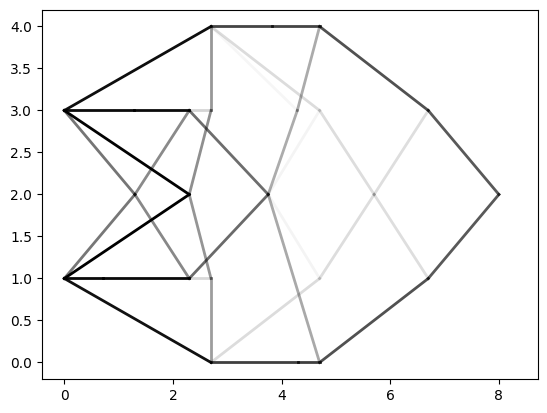



STEP: 2
Resulting projected perimeter: 46.00004973426778
Time 0.9809024333953857 s
Nodes: 45 Members: 634
Total time: 1.9297142028808594 s


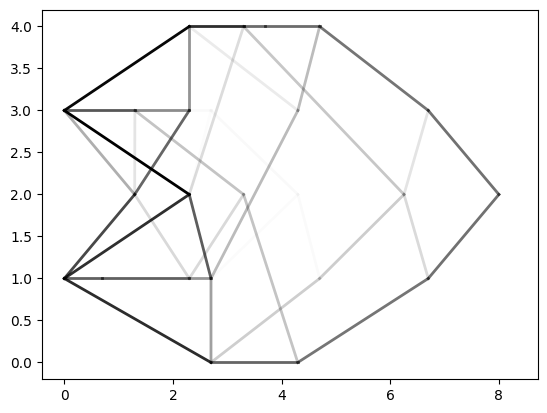



STEP: 3
Resulting projected perimeter: 50.20158573664007
Time 0.9811356067657471 s
Nodes: 45 Members: 634
Total time: 3.2216057777404785 s


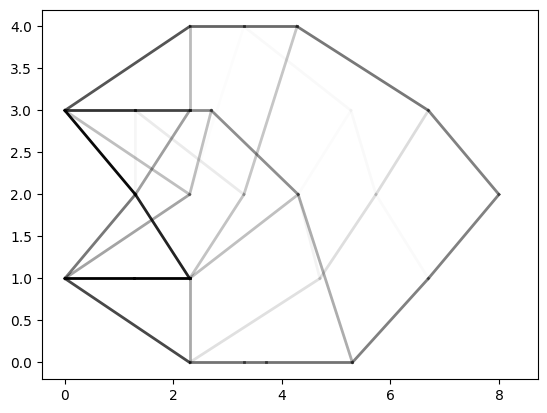



STEP: 4
Resulting projected perimeter: 47.60148736106284
Time 0.953657865524292 s
Nodes: 45 Members: 634
Total time: 4.632714509963989 s


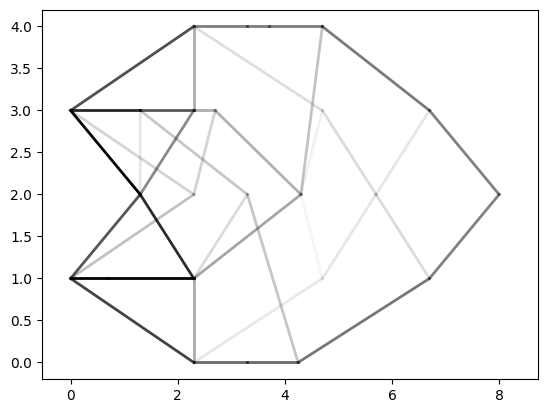



STEP: 5
Resulting projected perimeter: 47.00299902982389
Time 0.9342336654663086 s
Nodes: 45 Members: 634
Total time: 5.868048667907715 s


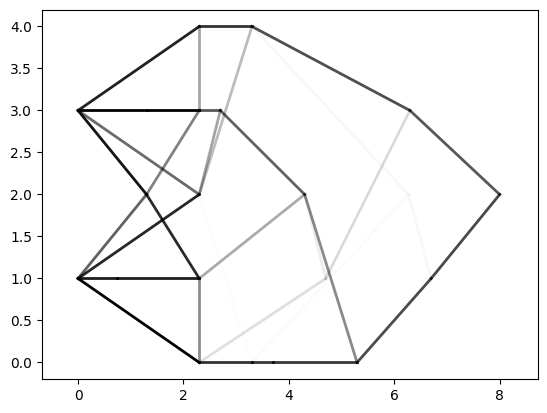



STEP: 6
Resulting projected perimeter: 46.480477619921196
Time 0.8993580341339111 s
Nodes: 45 Members: 634
Total time: 7.227444171905518 s


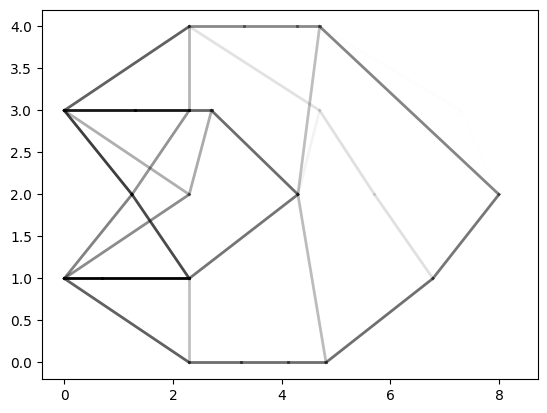



STEP: 7
Resulting projected perimeter: 44.10069973448712
Time 0.9550917148590088 s
Nodes: 45 Members: 634
Total time: 8.487476348876953 s


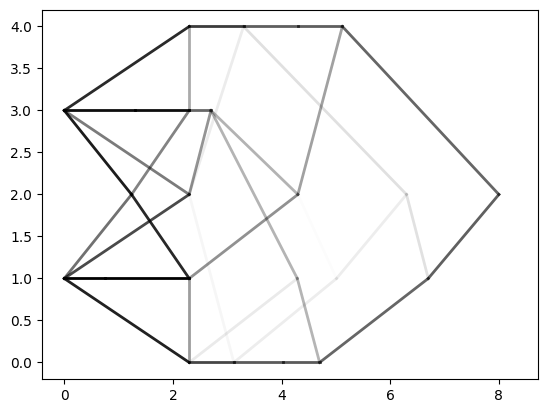



STEP: 8
Resulting projected perimeter: 46.585466041257895
Time 0.940009355545044 s
Nodes: 45 Members: 634
Total time: 9.73110580444336 s


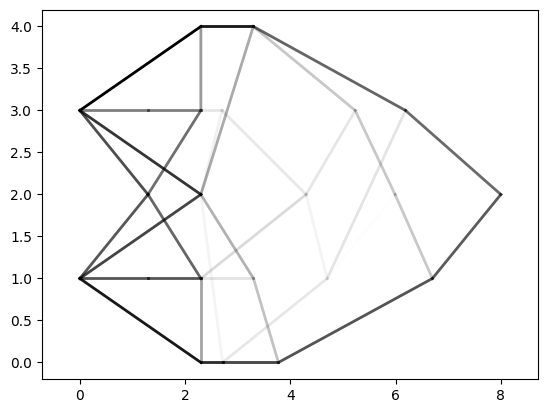



STEP: 9
Resulting projected perimeter: 46.20206315173299
Time 0.9843833446502686 s
Nodes: 45 Members: 634
Total time: 11.197630405426025 s


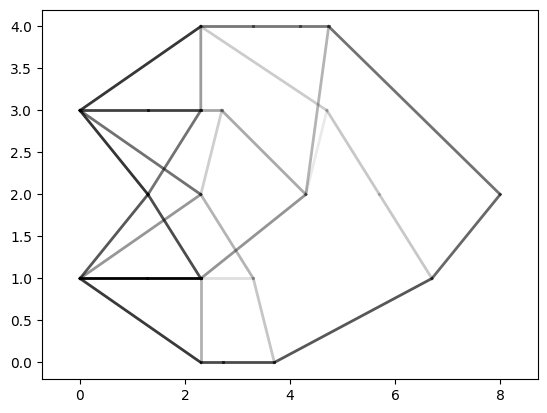



STEP: 10
Resulting projected perimeter: 41.800038067194365
Time 0.9578423500061035 s
Nodes: 45 Members: 634
Total time: 12.462918519973755 s


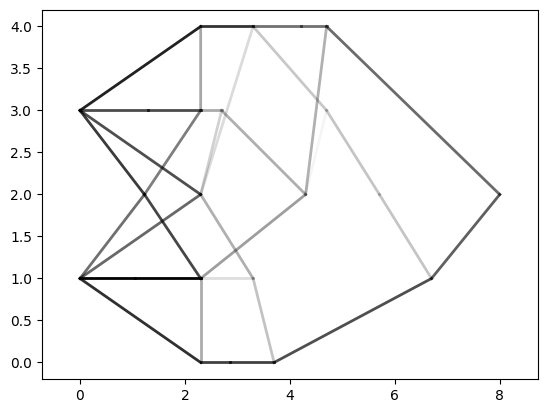



STEP: 11
Resulting projected perimeter: 44.60164390997032
Time 0.9740686416625977 s
Nodes: 45 Members: 634
Total time: 13.900612592697144 s


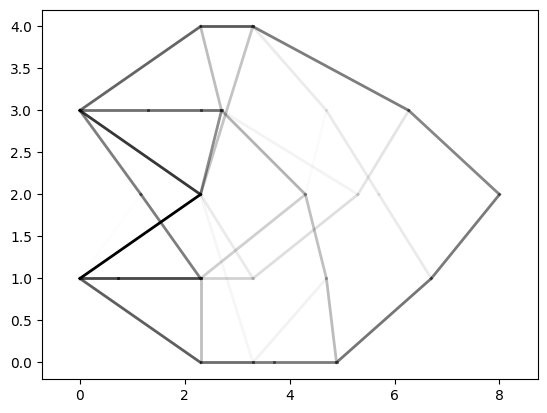



STEP: 12
Resulting projected perimeter: 47.60124693824744
Time 0.9752469062805176 s
Nodes: 45 Members: 634
Total time: 15.184956550598145 s


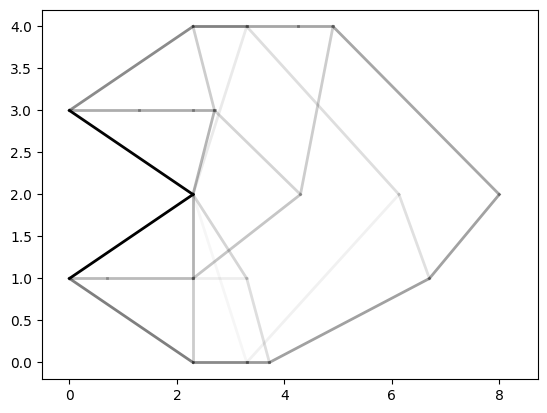



STEP: 13
Resulting projected perimeter: 40.60004705943915
Time 0.9562950134277344 s
Nodes: 45 Members: 634
Total time: 16.448245525360107 s


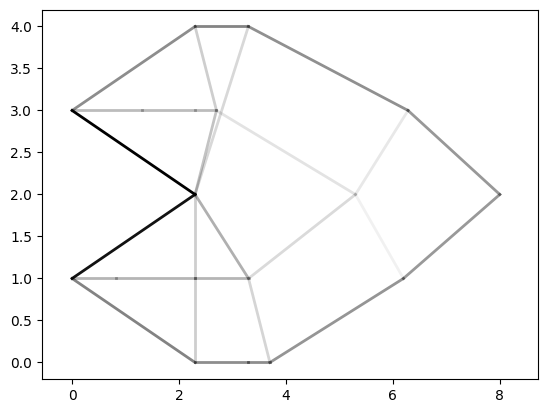



STEP: 14
Resulting projected perimeter: 34.60031148695843
Time 0.8690428733825684 s
Nodes: 45 Members: 634
Total time: 17.804524183273315 s


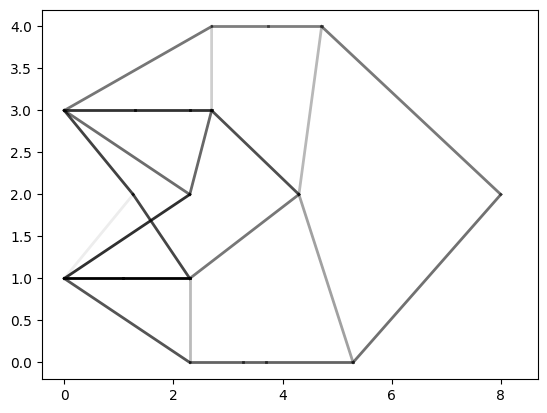



STEP: 15
Resulting projected perimeter: 33.40007133499403
Time 0.8868963718414307 s
Nodes: 45 Members: 634
Total time: 19.00100588798523 s


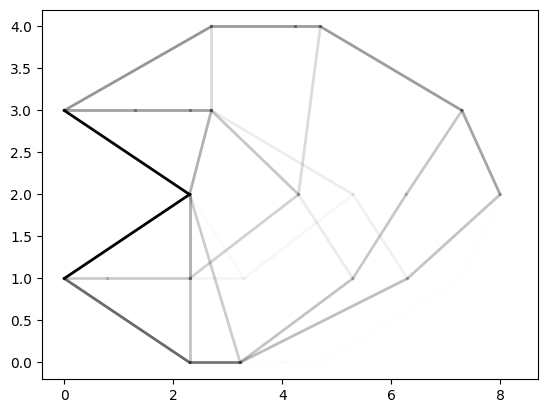



STEP: 16
Resulting projected perimeter: 48.501886654835666
Time 0.9264514446258545 s
Nodes: 45 Members: 634
Total time: 20.374568462371826 s


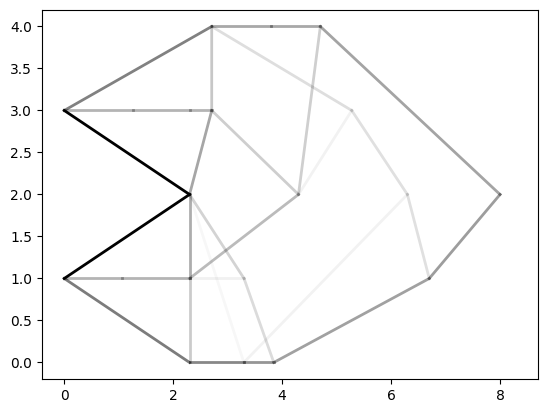



STEP: 17
Resulting projected perimeter: 40.200245861279924
Time 0.8887953758239746 s
Nodes: 45 Members: 634
Total time: 21.56850838661194 s


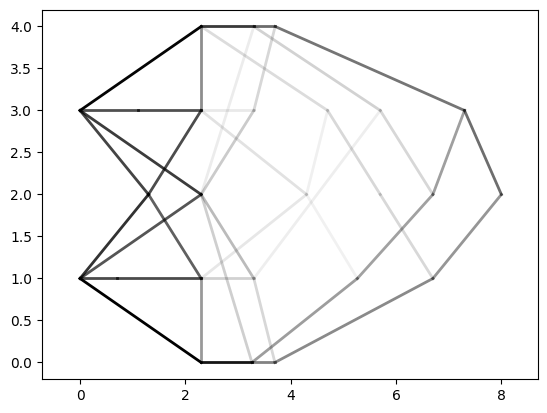



STEP: 18
Resulting projected perimeter: 55.60000066758246
Time 1.1066772937774658 s
Nodes: 45 Members: 634
Total time: 23.14379858970642 s


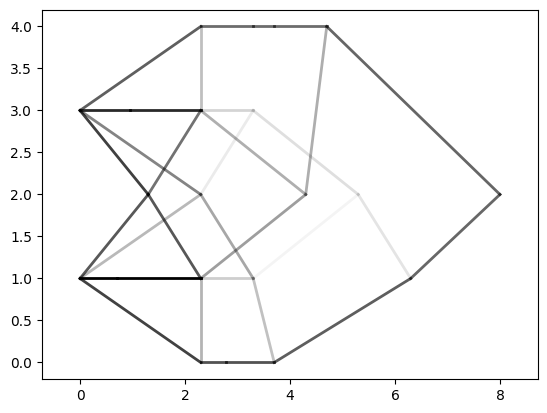



STEP: 19
Resulting projected perimeter: 43.00000001062114
Time 0.9199292659759521 s
Nodes: 45 Members: 634
Total time: 24.3758487701416 s


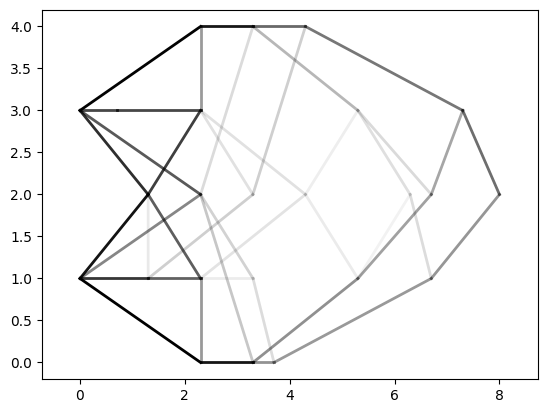



STEP: 20
Resulting projected perimeter: 52.80000000058492
Time 1.0112977027893066 s
Nodes: 45 Members: 634
Total time: 25.695271968841553 s


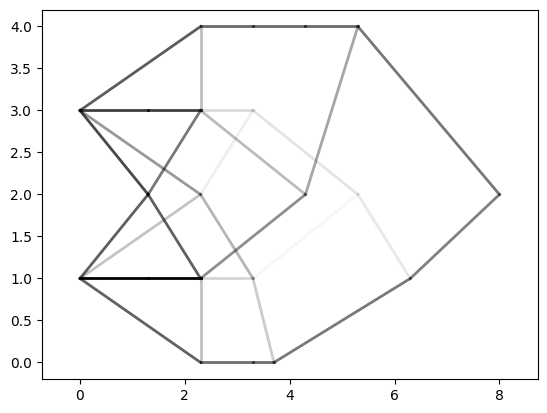



STEP: 21
Resulting projected perimeter: 43.599999999999994
Time 0.691211462020874 s
Nodes: 45 Members: 634
Total time: 26.883091926574707 s


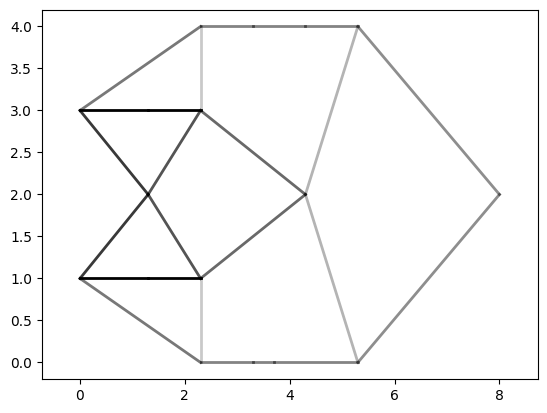



STEP: 22
Resulting projected perimeter: 31.199878397989416
Time 0.809760332107544 s
Nodes: 45 Members: 634
Total time: 27.997426748275757 s


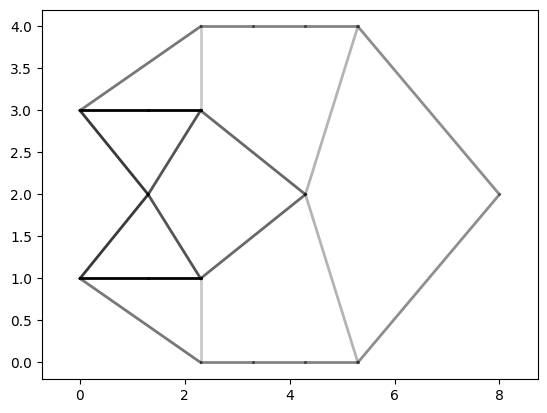



STEP: 23
Resulting projected perimeter: 30.00000000000002
Time 0.7406876087188721 s
Nodes: 45 Members: 634
Total time: 29.20347023010254 s


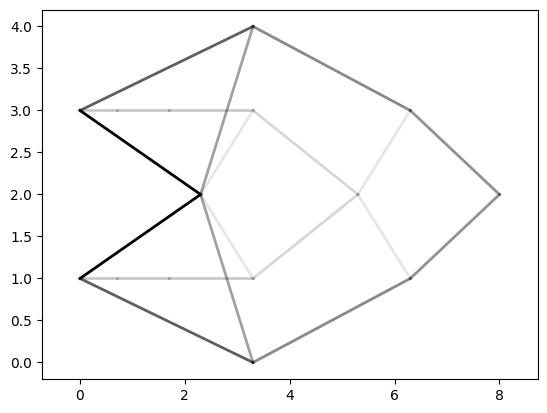



STEP: 24
Resulting projected perimeter: 37.19999999999999
Time 0.15004968643188477 s
Nodes: 45 Members: 634
Total time: 29.65963339805603 s


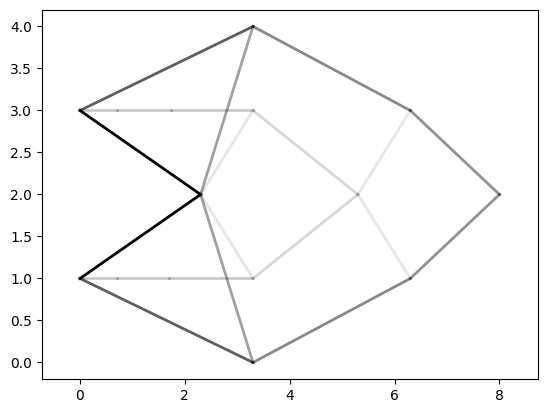



STEP: 25
Resulting projected perimeter: 37.19999999999999
Time 0.14403223991394043 s
Nodes: 45 Members: 634
Total time: 30.261143684387207 s


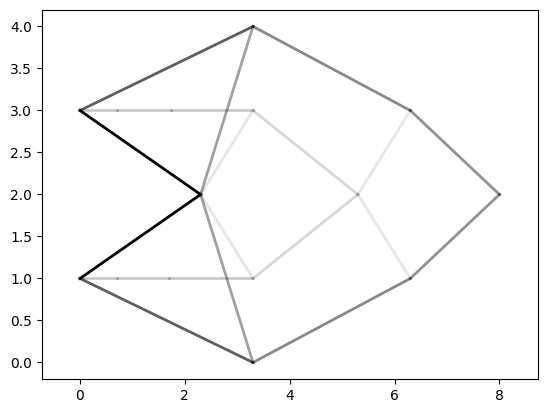

Resulting projected perimeter: 37.19999999999999


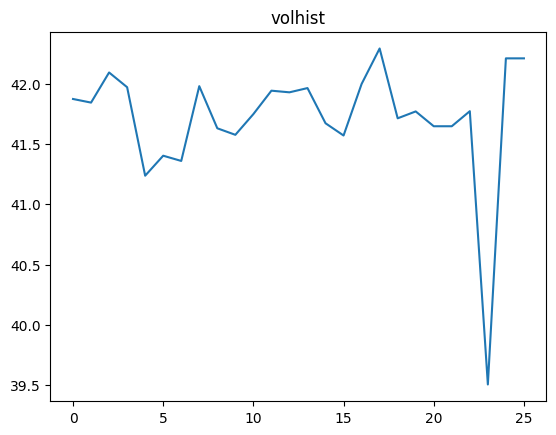

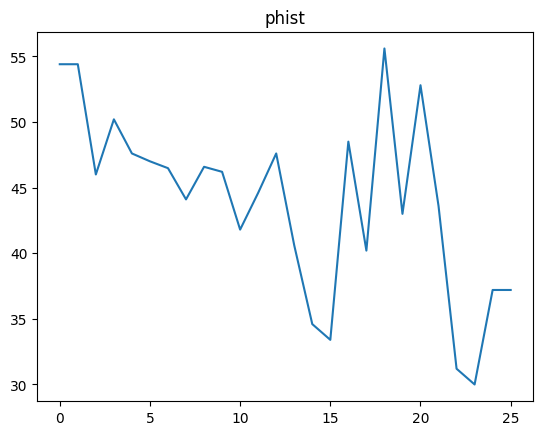

In [12]:
mbadd = 1000
counter = 1
difvol = volhist[-1]
difpp = phist[-1]
ttime = time.time()
while (((difvol/volhist[-1])>tolerance) or ((difpp/phist[-1])>tolerance)) and (counter<=100):
    print("\n\nSTEP:", counter)
    tempo = time.time()
    aauxcopy = copy.deepcopy(aaux)
    minimum = sc.optimize.minimize(comppjpm, coordauxaux[:, 0], args=(conecaux, aauxcopy), method='Nelder-Mead', bounds=bnds,
                                   options={'maxiter': 5000, 'disp': 0}, tol=tolerance)
    coordopt = minimum.x
    coordauxaux = copy.deepcopy(coordaux)
    coordauxaux[:, 0] = coordopt
    volhist.append(compvol(coordauxaux, conecaux, aauxcopy))
    phist.append(comppjpm(coordauxaux[:,0], conecaux, aauxcopy))
    pp = 0
    for i, m in enumerate(conec):
        if aaux[i] > areafloor:
            pp = pp+abs(coordauxaux[int(m[1])-1][0]-coordauxaux[int(m[0])-1][0])
    print("Resulting projected perimeter:", pp)
    print("Time", time.time()-tempo, "s")
    difvol = abs(volhist[-2]-volhist[-1])
    difpp = abs(phist[-2]-phist[-1])
    counter += 1
    aaux, tens = trussopt(coordauxaux, f, dof, stt, stc, mbadd)
    print("Total time:", time.time()-ttime, "s")
    plt.figure(6)
    plotlarea(conecaux, coordauxaux, None, aaux)
    plt.show()
pp = 0
for i, m in enumerate(conec):
    if aaux[i] > areafloor:
        pp = pp+abs(coordauxaux[int(m[1])-1][0]-coordauxaux[int(m[0])-1][0])
print("Resulting projected perimeter:", pp)
plt.figure(4)
plt.plot(volhist)
plt.title("volhist")
plt.figure(5)
plt.plot(phist)
plt.title("phist")
fhis.append(compvol(coordauxaux, conecaux, aaux))
fpp.append(comppjpm(coordauxaux[:,0], conecaux, aaux))

Nodes: 45 Members: 634


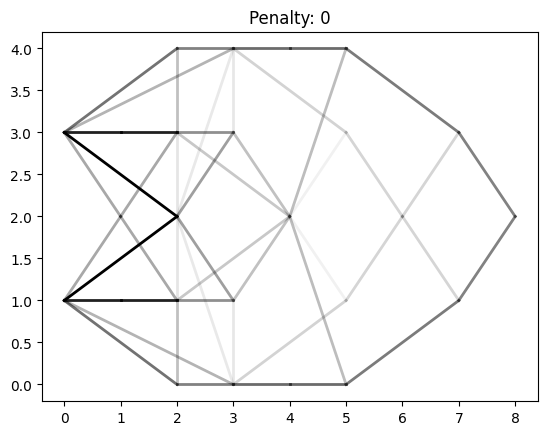

Nodes: 45 Members: 634


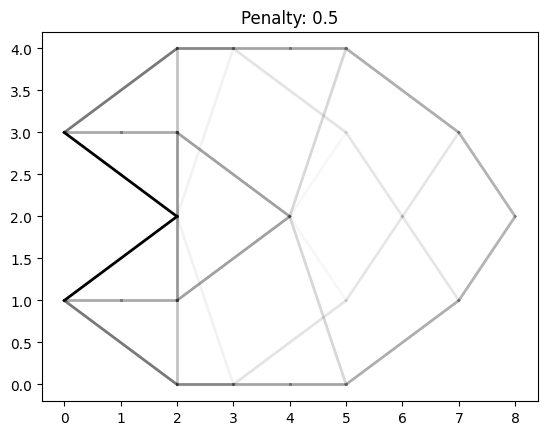

Nodes: 45 Members: 634


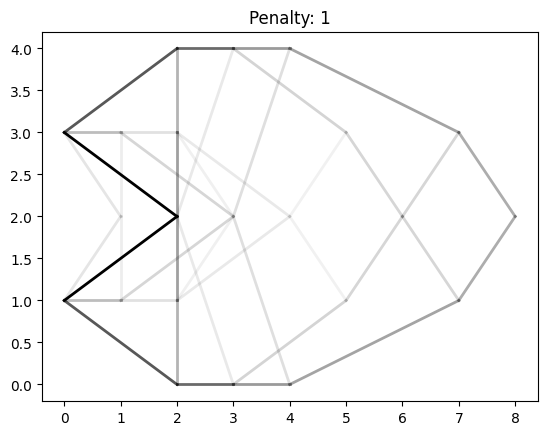

Nodes: 45 Members: 634


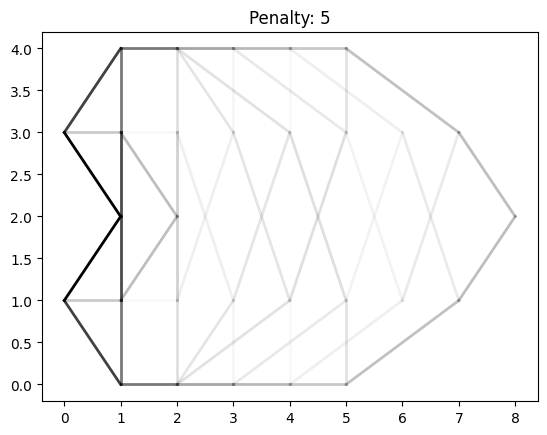

Nodes: 45 Members: 634


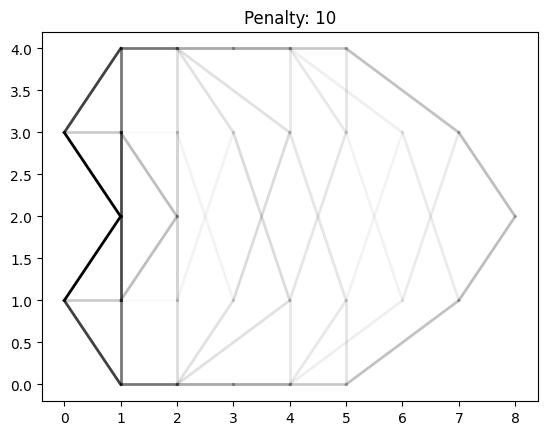

Nodes: 45 Members: 634


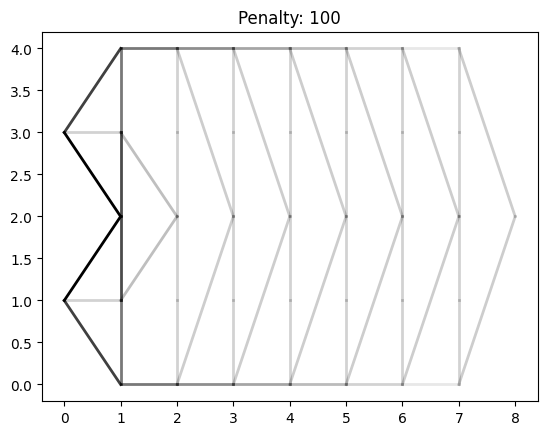

Nodes: 45 Members: 634


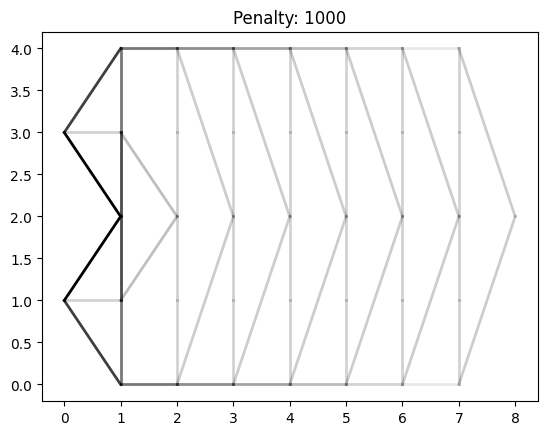

Nodes: 45 Members: 634


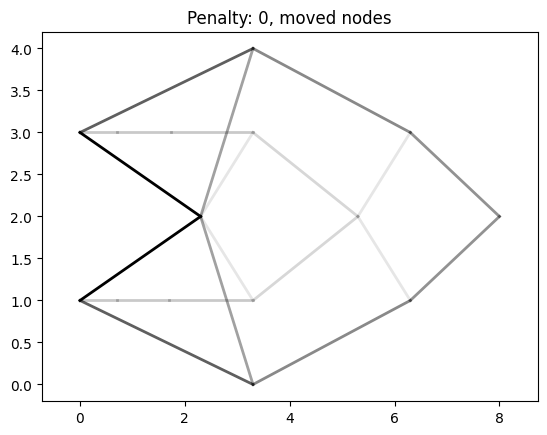

Nodes: 45 Members: 634


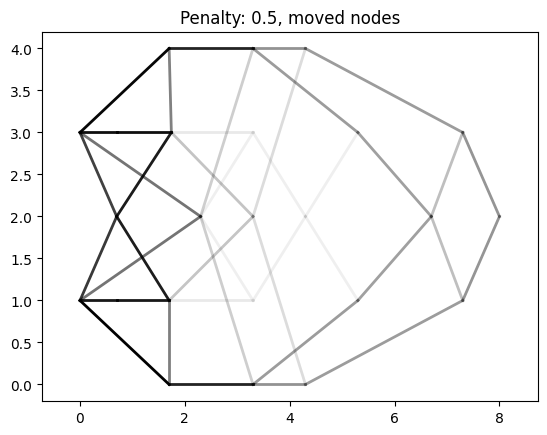

Nodes: 45 Members: 634


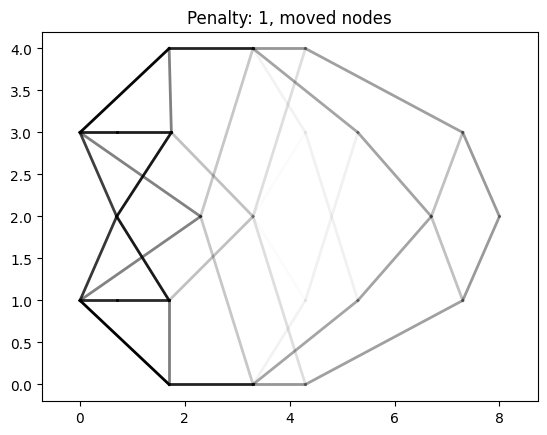

Nodes: 45 Members: 634


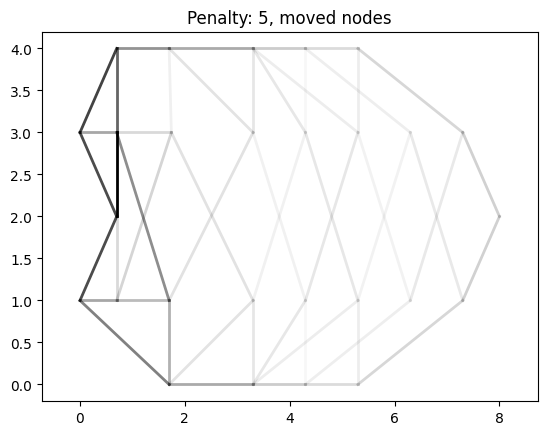

Nodes: 45 Members: 634


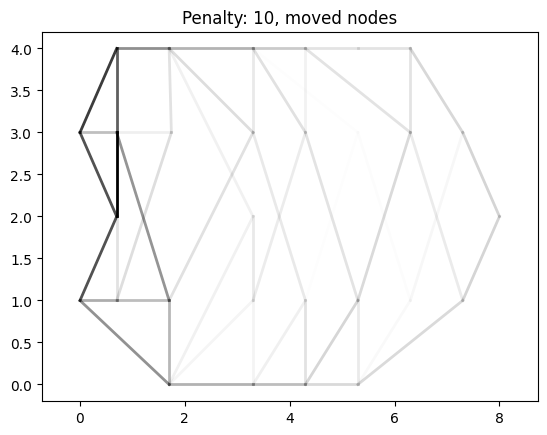

Nodes: 45 Members: 634


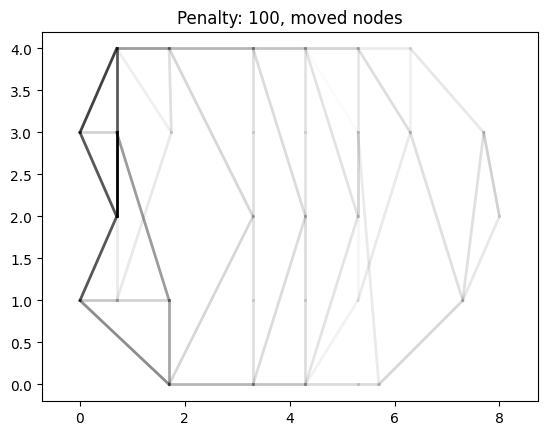

Nodes: 45 Members: 634


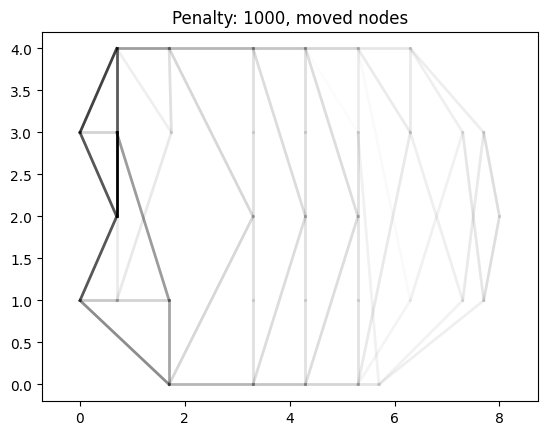

In [13]:
for p in [0,0.5,1,5,10,100,1000]:
    penalty = p
    aaux, tens = trussopt(coord, f, dof, stt, stc, mbadd)
    fhis.append(compvol(coord, conecaux, aaux))
    fpp.append(comppjpm(coord[:,0], conecaux, aaux))
    plotlarea(conecaux, coord, None, aaux)
    plt.title("Penalty: {}".format(p))
    plt.show()
for p in [0,0.5,1,5,10,100,1000]:
    penalty = p
    aaux, tens = trussopt(coordauxaux, f, dof, stt, stc, mbadd)
    fhis.append(compvol(coordauxaux, conecaux, aaux))
    fpp.append(comppjpm(coordauxaux[:,0], conecaux, aaux))
    plotlarea(conecaux, coordauxaux, None, aaux)
    plt.title("Penalty: {}, moved nodes".format(p))
    plt.show()

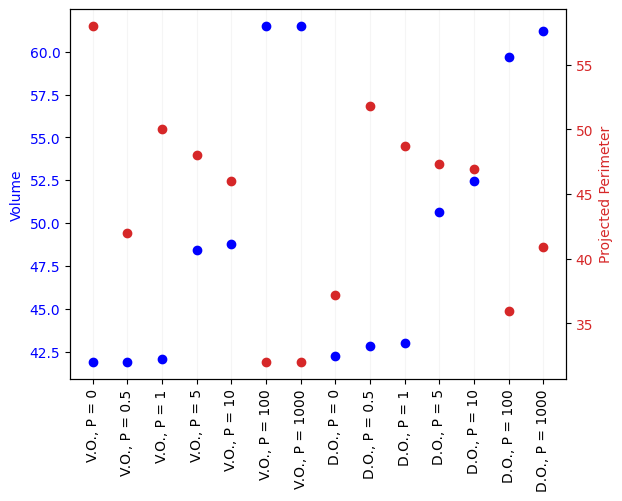

In [14]:
del fhis[0]
del fpp[0]
fig, ax1 = plt.subplots()
plt.grid(axis="x",color="whitesmoke")
x_ticks_labels = ["V.O., P = 0", "V.O., P = 0.5", "V.O., P = 1", "V.O., P = 5", "V.O., P = 10", "V.O., P = 100", "V.O., P = 1000", "D.O., P = 0", "D.O., P = 0.5", "D.O., P = 1", "D.O., P = 5", "D.O., P = 10", "D.O., P = 100", "D.O., P = 1000"]

ax1.set_ylabel("Volume", color='blue')
ax1.tick_params(axis='y', labelcolor="blue")
ax1.plot(fhis, "o", color='blue')
ax1.set_xticks(range(14))
ax1.set_xticklabels(x_ticks_labels, rotation='vertical')

ax2 = ax1.twinx()
ax2.set_ylabel("Projected Perimeter", color='tab:red')
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.plot(fpp, "o", color='tab:red')

plt.show()

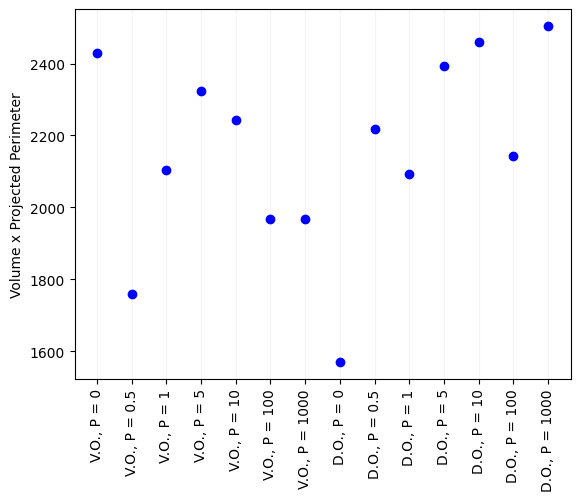

In [15]:
fig, ax1 = plt.subplots()
plt.grid(axis="x",color="whitesmoke")
x_ticks_labels = ["V.O., P = 0", "V.O., P = 0.5", "V.O., P = 1", "V.O., P = 5", "V.O., P = 10", "V.O., P = 100", "V.O., P = 1000", "D.O., P = 0", "D.O., P = 0.5", "D.O., P = 1", "D.O., P = 5", "D.O., P = 10", "D.O., P = 100", "D.O., P = 1000"]

ax1.set_ylabel("Volume x Projected Perimeter")
ax1.tick_params(axis='y')
ax1.set_xticks(range(14))
ax1.set_xticklabels(x_ticks_labels, rotation='vertical')
ax1.plot(np.multiply(fhis, fpp), "o", color="blue")

plt.show()

0.0978705883026123


Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

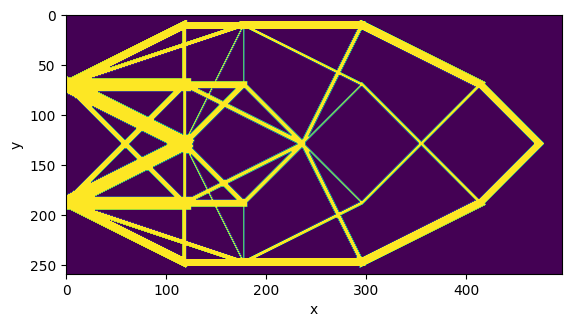

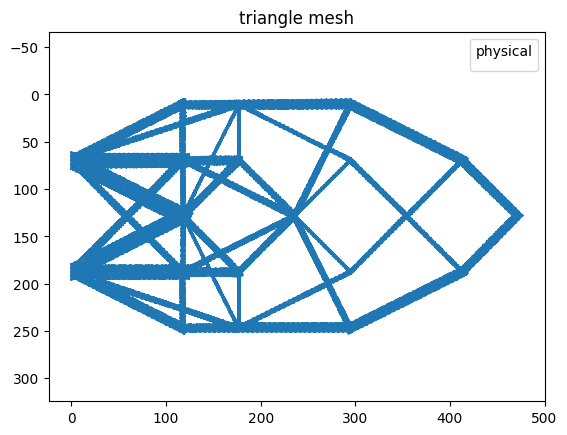

In [16]:
gray_file = skimage.io.imread("test.png", as_gray=1)
threshold = skimage.filters.threshold_otsu(gray_file) #input value
binary_file = (gray_file > threshold) #binary is when less than trheshold
plane = Image(~binary_file)
plane.show()

tempo = time.time()
mesher = Mesher2D(plane)
mesher.generate_contour(max_edge_dist=10)
# mesher.plot_contour()
mesh = mesher.triangulate(opts='q30a10')  # https://rufat.be/triangle/API.html#triangle.triangulate
# plane.compare_with_mesh(mesh)
# plt.show()

triangles = mesh.get('triangle')
i = 1
while triangles.remove_cells(label=i):
        triangles.remove_cells(label=i)
        i+=1
triangles.remove_cells(label=i+1)

ax = triangles.plot()
print(time.time()-tempo)
plt.savefig('figure1.pdf')
triangles.write('out.msh', file_format='gmsh22', binary=False)
plt.show()